In [192]:
# Imports

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Index(['CD_REGIAO', 'NM_REGIAO', 'CD_UF', 'NM_UF', 'CD_MUN', 'NM_MUN',
       'CD_DIST', 'NM_DIST', 'CD_SUBDIST', 'NM_SUBDIST', 'CD_BAIRRO',
       'NM_BAIRRO', 'CD_RGINT', 'NM_RGINT', 'CD_RGI', 'NM_RGI', 'CD_CONCURB',
       'NM_CONCURB', 'geometry'],
      dtype='object') 

Bairros encontrados em Santos: 70


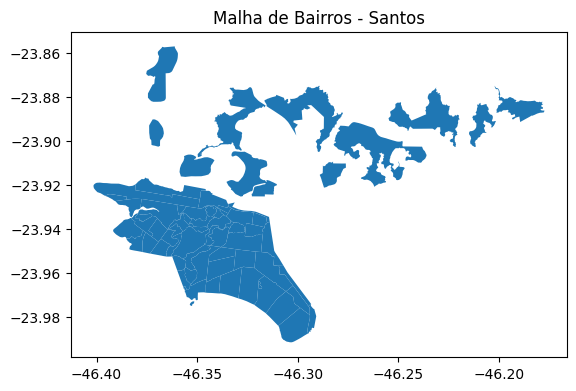

In [193]:
# Carregar o arquivo shapefile do estado de São Paulo usando geopandas

gdf_estado = gpd.read_file("zip://data/SP_bairros_CD2022.zip")

# Espiar as colunas disponíveis

print(gdf_estado.columns, '\n')

# Filtrando apenas Santos. O código do IBGE para Santos é '3548500'

gdf_santos = gdf_estado[gdf_estado['CD_MUN'].astype(str) == '3548500'].copy()

# Verificar o resultado

print(f"Bairros encontrados em Santos: {len(gdf_santos)}")
gdf_santos.plot()
plt.title("Malha de Bairros - Santos")
plt.show()

In [194]:
# Carregar os dois arquivos CSV de dados criminais de 2025 (jan-jun e jul-nov)

df_part_1 = pd.read_csv('data\SPDadosCriminais_2025_part1.csv', encoding = 'latin1', sep = ';')
df_part_2 = pd.read_csv('data\SPDadosCriminais_2025_part2.csv', encoding = 'latin1', sep = ';')
df_total = pd.concat([df_part_1, df_part_2], ignore_index=True)

# Conferindo

print("\nDados Carregados:")
print(f"Linhas Jan-Jun: {len(df_part_1)}")
print(f"Linhas Jul-Nov: {len(df_part_2)}")
print(f"Total Empilhado: {len(df_total)}")

<>:3: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:4: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:3: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:4: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
C:\Users\USER\AppData\Local\Temp\ipykernel_11064\2309608426.py:3: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  df_part_1 = pd.read_csv('data\SPDadosCriminais_2025_part1.csv', encoding = 'latin1', sep = ';')
C:\Users\USER\AppData\Local\Temp\ipykernel_11064\2309608426.py:4: SyntaxWarni


Dados Carregados:
Linhas Jan-Jun: 585427
Linhas Jul-Nov: 483578
Total Empilhado: 1069005


In [195]:
# Filtrando Santos nos dados criminais

df_santos = df_total[df_total['NOME_MUNICIPIO_CIRCUNSCRICAO'].str.strip() == 'SANTOS'].copy()
print(f"Total de linhas reais de Santos: {len(df_santos)}")

#df_santos.to_csv('data/SP_dados_criminais_santos_2025.csv', index=False, encoding='latin1', sep=';') # Salvando o CSV apenas com dados de Santos

Total de linhas reais de Santos: 10222


## Pré-Processamento e Tratamento

In [196]:
out_of_bounds = [
    'ITARARÉ', 'ITARARE', 'VILA CASCATINHA', 'CIDADE NAUTICA', 
    'JARDIM GUASSU', 'JARDIM BOA ESPERANCA (VICENTE DE CARVALHO)',
    'VILA NOVA SAO VICENTE', 'VILA DOS PESCADORES', 'JD ALBATROZ II',
    'INDAIÁ', 'INDAIA', 'VILA LIGYA', 'CANAL 02', ' ', 'PORTO' # Porto sozinho é muito vago, melhor remover ou assumir Macuco
]

neighborhood_map = {

    # Erros de Gráfia

    'BOQUEIRAO': 'BOQUEIRÃO',
    'SABOO': 'SABOÓ',
    'SABOÓ': 'SABOÓ', 
    'EMBARE': 'EMBARÉ',
    'MARAPE': 'MARAPÉ',
    'POMPEIA': 'POMPÉIA',
    'JARDIM RADIO CLUBE': 'RÁDIO CLUBE',
    'JD RADIO CLUBE': 'RÁDIO CLUBE',
    'RADIO CLUBE': 'RÁDIO CLUBE',
    'SAO JORGE': 'SÃO JORGE',
    'VILA SAO JORGE': 'SÃO JORGE',
    'SAO MANOEL': 'SÃO MANOEL',
    'SÃO JOSÉ': 'SÃO MANOEL', # Frequentemente confundido
    'PAQUETA': 'PAQUETÁ',
    'ESTUARIO': 'ESTUÁRIO',
    'VILA MATIAS': 'VILA MATIAS',
    
    # Variações

    'VILA MATHIAS': 'VILA MATIAS', 
    'OUTEIRINHOS': 'OUTEIRINHO',
    'BOM RETIRO': 'BOM RETIRO', 
    'VILA NOVA': 'VILA NOVA', 
    
    # Morros

    'MORRO DE SÃO BENTO': 'MORRO SÃO BENTO',
    'MORRO SAO BENTO': 'MORRO SÃO BENTO',
    'MORRO DO PACHECO': 'MORRO PACHECO',
    'MORRO DO MARAPÉ': 'MORRO MARAPÉ',
    'MORRO DO MARAPE': 'MORRO MARAPÉ',
    'MORRO DO SABOO': 'MORRO SABOÓ',
    'MORRO DO MONTE SERRAT': 'MONTE SERRAT',
    'MORRO MONTE SERRAT': 'MONTE SERRAT',
    'MORRO DA PENHA': 'MORRO PENHA',
    'MORRO DO BUFO': 'MORRO PACHECO', 
    'VALE DO QUILOMBO': 'QUILOMBO',
    
    # Portos/Docas

    'DOCAS': 'PORTO MACUCO',
    'PORTO SABOO': 'PORTO SABOÓ',
    'PORTO PAQUETA': 'PORTO PAQUETÁ',
    
    # Área Continental
    'AREA RURAL': 'CARUARA', 
    'ÁREA CONTINENTAL': 'CARUARA',
    'CACHOEIRA': 'CARUARA',
    'CHÁCARAS': 'CARUARA'
}

In [197]:
# Função para limpar e padronizar os nomes dos bairros

def clean_neighborhood(neighborhood):
    if pd.isna(neighborhood): return None
    
    # Normalização Básica

    neighborhood_clean = str(neighborhood).upper().strip()
    
    # Verifica se é Lixo (Outras cidades)
    
    if neighborhood_clean in out_of_bounds:
        return None
        
    # Tenta Traduzir pelo Dicionário. Se estiver no dicionário, pega o valor novo. Se não, mantém o original (limpo).

    if neighborhood_clean in neighborhood_map:
        return neighborhood_map[neighborhood_clean]

    return neighborhood_clean

In [198]:
# Aplicando a função de limpeza

df_santos['BAIRRO_LIMPO'] = df_santos['BAIRRO'].apply(clean_neighborhood)
df_santos_limpo = df_santos.dropna(subset=['BAIRRO_LIMPO']).copy() # Remove os que viraram None (Lixo)  

# Check de Sucesso

print(f"Linhas Originais: {len(df_santos)}")
print(f"Linhas Após Limpeza: {len(df_santos_limpo)}")

Linhas Originais: 10222
Linhas Após Limpeza: 10181


In [199]:
# Função para definir o período do dia com base na hora

def define_period(h):
    if 6 <= h < 12: return 'MANHÃ'
    elif 12 <= h < 18: return 'TARDE'
    elif 18 <= h < 24: return 'NOITE'
    else: return 'MADRUGADA' # 00h as 06h

In [200]:
# Aplicando o mapeamento de hora

df_santos_limpo['HORA_LIMPA'] = df_santos_limpo['HORA_OCORRENCIA_BO'].fillna('00:00').astype(str)
df_santos_limpo['HORA_INT'] = df_santos_limpo['HORA_LIMPA'].apply(lambda x: int(x.split(':')[0]) if ':' in x else 0)

df_santos_limpo['PERIODO'] = df_santos_limpo['HORA_INT'].apply(define_period)

print("Distribuição de Crimes por Período:\n")
print(df_santos_limpo['PERIODO'].value_counts())

Distribuição de Crimes por Período:

PERIODO
MADRUGADA    3738
TARDE        2525
NOITE        2106
MANHÃ        1812
Name: count, dtype: int64


In [201]:
df_santos_limpo['IS_NOITE'] = df_santos_limpo['PERIODO'].str.contains('NOITE|MADRUGADA', case=False, na=False)
df_santos_limpo['IS_DIA'] = df_santos_limpo['PERIODO'].str.contains('MANHÃ|TARDE', case=False, na=False)

print("\nDistribuição de Crimes à Noite vs Dia:\n")
print(df_santos_limpo['IS_NOITE'].value_counts())


Distribuição de Crimes à Noite vs Dia:

IS_NOITE
True     5844
False    4337
Name: count, dtype: int64


In [202]:
crime_categories = {
    'ROUBO - OUTROS': 'Roubos (Geral)', 'ROUBO DE VEÍCULO': 'Roubo de Veículos', 'ROUBO DE CARGA': 'Roubos (Geral)',
    'LESÃO CORPORAL DOLOSA': 'Agressão / Lesão', 'TENTATIVA DE HOMICÍDIO': 'Crimes contra a Vida',
    'HOMICÍDIO DOLOSO': 'Crimes contra a Vida', 'HOMICÍDIO CULPOSO OUTROS': 'Crimes contra a Vida',
    'HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO': 'Acidentes de Trânsito',
    'FURTO - OUTROS': 'Furtos (Geral)', 'FURTO DE VEÍCULO': 'Furto de Veículos', 'FURTO DE CARGA': 'Furtos (Geral)',
    'ESTUPRO': 'Crimes Sexuais', 'ESTUPRO DE VULNERÁVEL': 'Crimes Sexuais',
    'TRÁFICO DE ENTORPECENTES': 'Drogas e Armas', 'PORTE DE ENTORPECENTES': 'Drogas e Armas',
    'APREENSÃO DE ENTORPECENTES': 'Drogas e Armas', 'PORTE DE ARMA': 'Drogas e Armas',
    'LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO': 'Acidentes de Trânsito',
    'LESÃO CORPORAL CULPOSA - OUTRAS': 'Agressão / Lesão'
}

crime_weights = {
    'HOMICÍDIO DOLOSO': 10, 'ESTUPRO': 10, 'ESTUPRO DE VULNERÁVEL': 10, 'TENTATIVA DE HOMICÍDIO': 8,
    'ROUBO - OUTROS': 6, 'ROUBO DE VEÍCULO': 6, 'ROUBO DE CARGA': 6, 'LESÃO CORPORAL DOLOSA': 5,
    'HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO': 4,
    'TRÁFICO DE ENTORPECENTES': 3, 'PORTE DE ARMA': 3,
    'FURTO - OUTROS': 2, 'FURTO DE VEÍCULO': 2, 'FURTO DE CARGA': 2
}

In [203]:
df_santos_limpo['CATEGORY'] = df_santos_limpo['NATUREZA_APURADA'].map(crime_categories).fillna('Outros')
df_santos_limpo['WEIGHT'] = df_santos_limpo['NATUREZA_APURADA'].map(crime_weights).fillna(1)

In [204]:
# Criando colunas para cada categoria

for category in df_santos_limpo['CATEGORY'].unique():

    # Se a linha for daquela categoria, conta como 1 ocorrência, senão 0.

    df_santos_limpo[category] = np.where(df_santos_limpo['CATEGORY'] == category, 1, 0)

# Agrupamento por Bairro

c_columns = list(df_santos_limpo['CATEGORY'].unique())
c_columns

['Furtos (Geral)',
 'Furto de Veículos',
 'Acidentes de Trânsito',
 'Crimes contra a Vida',
 'Agressão / Lesão',
 'Roubos (Geral)',
 'Drogas e Armas',
 'Crimes Sexuais',
 'Roubo de Veículos']

In [205]:
# Agrupando por Bairro e calculando métricas (soma dos pesos: índice de perigo absoluto, natureza apurada: total de crimes)

df_grouped = df_santos_limpo.groupby('BAIRRO_LIMPO').agg({
    'WEIGHT': 'sum',            # Soma dos pesos (Índice de Perigo Absoluto)
    'NATUREZA_APURADA': 'count',
    'IS_NOITE': 'sum',
    'IS_DIA': 'sum',
    **{c: 'sum' for c in c_columns} # Adiciona todas as categorias dinamicamente
}).reset_index()

# Renomeando 

df_grouped.rename(columns={
    'WEIGHT': 'TOTAL_DANGER_SCORE', 
    'NATUREZA_APURADA': 'TOTAL_CRIMES',
    'IS_NOITE': 'NIGHT_CRIMES',
    'IS_DIA': 'DAY_CRIMES'
}, inplace=True)

In [206]:
# Merge dos dados agrupados com o GeoDataFrame dos bairros de Santos

gdf_santos['NM_BAIRRO_MATCH'] = gdf_santos['NM_BAIRRO'].astype(str).str.upper().str.strip()

# Preparação da Geometria. garantimos que temos 1 polígono por bairro (Dissolve)

gdf_santos_unique = gdf_santos.dissolve(by='NM_BAIRRO_MATCH', as_index=False)


# Projeção para Métrico (Brasil/SP usa SIRGAS 2000 / UTM zone 23S = EPSG:31983) e calcula de área

gdf_santos_unique = gdf_santos_unique.to_crs(epsg=31983)
gdf_santos_unique['AREA_KM2'] = gdf_santos_unique.geometry.area / 1e6 # Calcula km² (Área em m² dividida por 1 milhão)
gdf_santos_unique = gdf_santos_unique.to_crs(epsg=4326)

In [207]:
# O Merge (Left Join)

# Geodata é um novo GeoDataFrame. Ele é o equivalente a injetar dados em um geojson.

geodata = gdf_santos_unique.merge(
    df_grouped, 
    left_on='NM_BAIRRO_MATCH', 
    right_on='BAIRRO_LIMPO', 
    how='left'
)

geodata

# Tratamento de Bairros sem Crimes

geodata['TOTAL_DANGER_SCORE'] = geodata['TOTAL_DANGER_SCORE'].fillna(0)
geodata['TOTAL_CRIMES'] = geodata['TOTAL_CRIMES'].fillna(0)

# Métrica de Densidade de Perigo (Perigo por km²)

geodata['DANGER_DENSITY'] = geodata['TOTAL_DANGER_SCORE'] / geodata['AREA_KM2']

In [208]:
# Aplicando Square Root 

sqrt_density = np.sqrt(geodata['DANGER_DENSITY'])
min_s, max_s = sqrt_density.min(), sqrt_density.max()

# Normalização de 1.0 a 10.0 (evita o zero)

if max_s > min_s:
    geodata['SAFETY_SCORE'] = 10 - ((sqrt_density - min_s) / (max_s - min_s) * 9)
else:
    geodata['SAFETY_SCORE'] = 10.0

geodata['SAFETY_SCORE'] = geodata['SAFETY_SCORE'].round(1)

In [209]:
continental = [
    'CARUARA', 'IRIRI', 'GUARAPÁ', 'MONTE CABRÃO', 
    'ILHA BARNABÉ', 'QUILOMBO', 'AREA RURAL', 'ÁREA CONTINENTAL',
    'NOSSA SENHORA DAS NEVES', 'PIAÇAGUERA', 'BAGRES', 'TRINDADE', 'CABUÇU'
]

urban_geodata = geodata[~geodata['NM_BAIRRO_MATCH'].isin(continental)].copy()

In [210]:
# Mapa Base

mapa_santos_crimes = folium.Map(
                        location=[-23.9618, -46.3322],
                        zoom_start=12,
                        tiles='cartodbpositron',
)


# Mapa CoroplÉtico

folium.Choropleth(  
        geo_data = urban_geodata,
        data = urban_geodata,
        columns = ['NM_BAIRRO_MATCH', 'SAFETY_SCORE'],
        key_on = 'feature.properties.NM_BAIRRO_MATCH',
        fill_color='RdYlGn',
        fill_opacity = 0.7,
        line_opacity = 0.3,
        name = 'Mapa de Calor',
        legend_name = 'Ocorrências Criminais (2025)',
        highlight = True).add_to(mapa_santos_crimes),



style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.1, 'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1}


# GeoJson Hover

hover = folium.features.GeoJson(data = geodata, 
                                style_function = style_function,
                                control = False,
                                highlight_function = highlight_function,
                                tooltip = folium.features.GeoJsonTooltip(fields = ['NM_BAIRRO_MATCH', 'TOTAL_CRIMES', 'SAFETY_SCORE'],
                                                                      aliases = ['Bairro:', 'Ocorrências:', 'Índice de Segurança:'],
                                                                      style = ('background-scolor: white; color: black; padding: 16px;'),
                                                                      localize = True
    )
)

mapa_santos_crimes.add_child(hover)
mapa_santos_crimes.keep_in_front(hover)
folium.LayerControl().add_to(mapa_santos_crimes)    

In [211]:
# Salvar o GeoDataFrame

urban_geodata.to_file("data/santos_data.geojson", driver='GeoJSON')
print("Arquivo 'santos_data.geojson' salvo com sucesso!")

Arquivo 'santos_data.geojson' salvo com sucesso!
